**K MEDIAN CLUSTERING** :
 now we want to measure kmeadian approach ...

 

In [ ]:
import sys

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [ ]:
# convert each image to 1 dimensional array

X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1

X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


In [ ]:
!pip install scikit-learn-extra
import scipy
from sklearn_extra.cluster import KMedoids
kmedoids= KMedoids(n_clusters=10)
kmedoids.fit(X[:100,])
kmedoids.labels_

array([6, 4, 5, 2, 9, 9, 7, 4, 7, 3, 6, 0, 6, 1, 7, 3, 9, 3, 5, 3, 9, 4,
       9, 2, 1, 4, 9, 6, 3, 2, 7, 0, 5, 3, 4, 0, 1, 4, 7, 1, 5, 2, 7, 9,
       6, 9, 2, 9, 6, 6, 6, 4, 7, 8, 9, 3, 4, 9, 9, 2, 0, 2, 1, 4, 7, 8,
       1, 0, 5, 4, 5, 3, 5, 1, 6, 4, 0, 2, 2, 3, 6, 4, 4, 1, 7, 2, 7, 9,
       6, 9, 1, 3, 9, 1, 2, 4, 9, 3, 6, 2])

In [ ]:
kmedoids.fit(X[:30000,])
kmedoids.n_clusters

10

Since it crashes when we train all the 60K data, We just use half of data for clustering. now lets see the center of clusters.

100%|██████████| 10/10 [00:00<00:00, 72.06it/s]


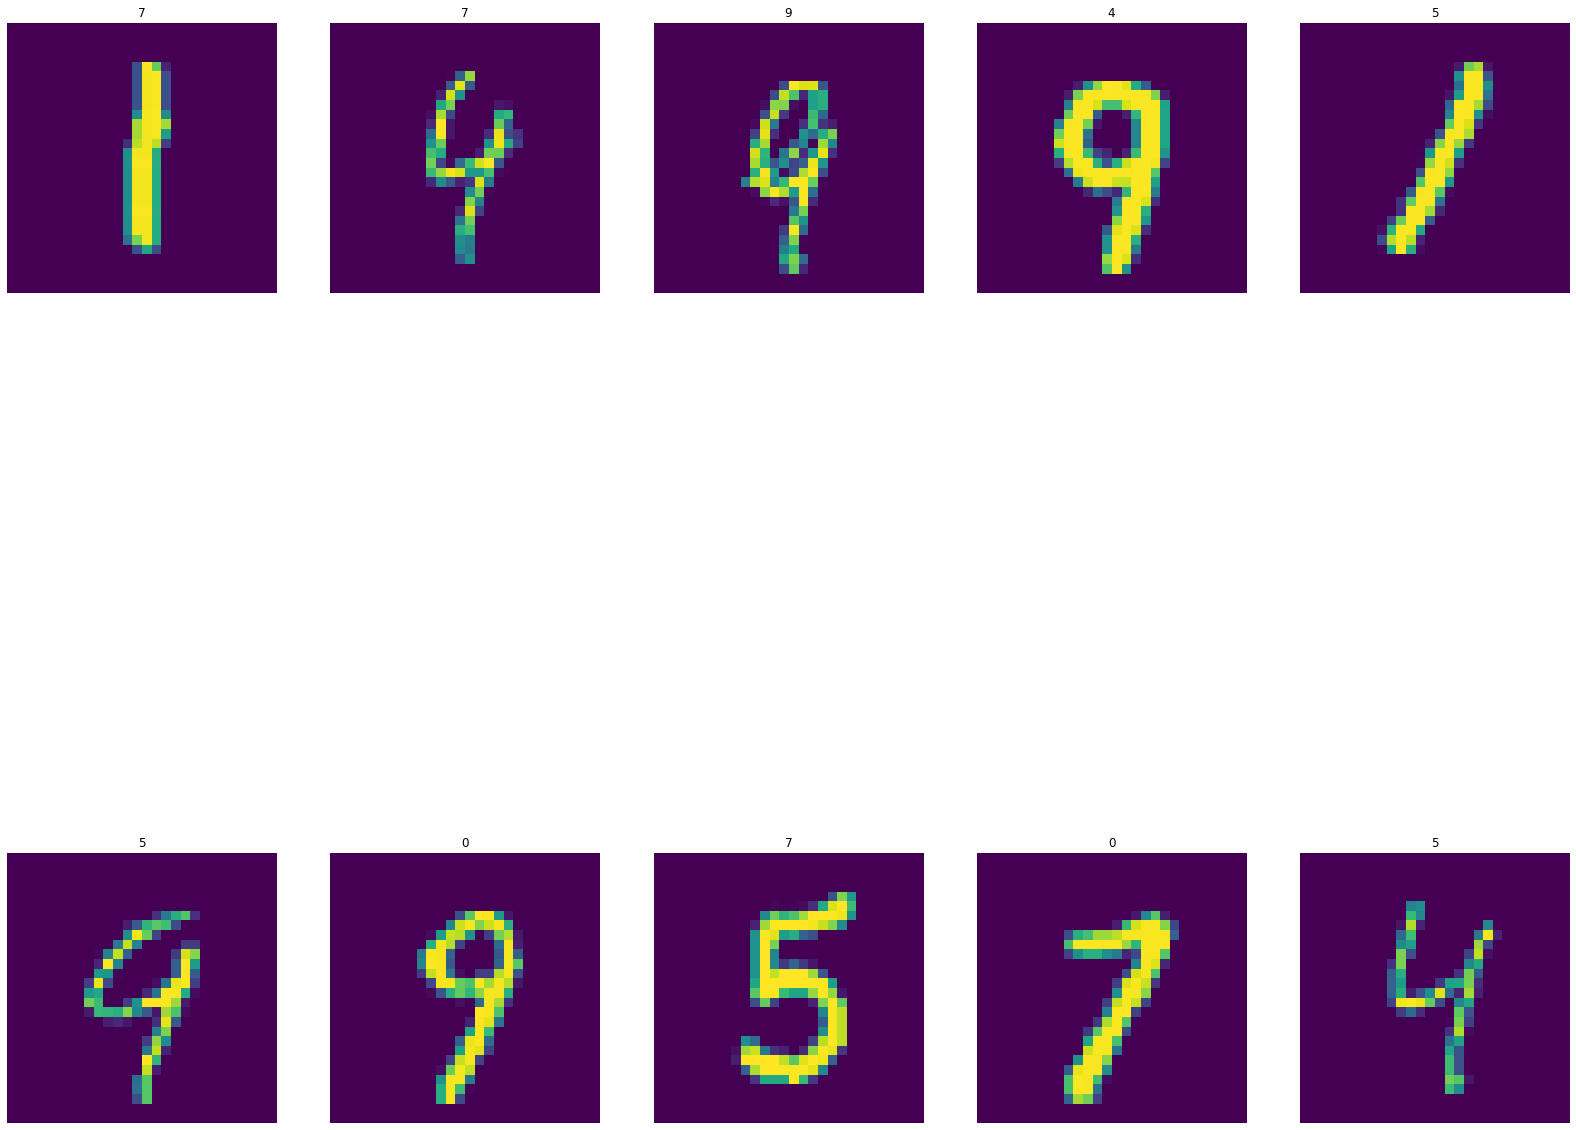

In [ ]:
from tqdm import tqdm
# record centroid values
centroids = kmedoids.cluster_centers_

# reshape centroids into images
images = centroids.reshape(10, 28, 28)

fig = plt.figure(figsize=(28,28))
  
# setting values to rows and column variables
rows = 2
columns = 5
one_count=0
for i in tqdm(range(10)):
    one_count+=1
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, one_count)
  
# showing image
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(kmedoids.labels_[i])

K-median clustering is an unsupervised machine learning method; consequently, the labels assigned by our Kmedians algorithm refer to the cluster each array was assigned to, not the actual target integer. To fix this, let’s define a few functions that will predict which integer corresponds to each cluster.

In [ ]:
def infer_cluster_labels(kmeans, actual_labels):
  inferred_labels = {}

  for i in range(kmeans.n_clusters):

    # find index of points in cluster
    labels = []
    index = np.where(kmeans.labels_ == i)
    #print("index is : " + str(index))
    # append actual labels for each point in cluster
    labels.append(actual_labels[index])
    #print("actual label  is : " + str(actual_labels[index]))
    # determine most common label
    if len(labels[0]) == 1:
        counts = np.bincount(labels[0])
    else:
        counts = np.bincount(np.squeeze(labels))

    # assign the cluster to a value in the inferred_labels dictionary
    if np.argmax(counts) in inferred_labels:
        # append the new number to the existing array at this slot
        inferred_labels[np.argmax(counts)].append(i)
    else:
        # create a new array in this slot
        inferred_labels[np.argmax(counts)] = [i]

    print(labels)
    print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
    
  return inferred_labels



[array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)]
Cluster: 0, label: 1
[array([6, 6, 7, ..., 6, 8, 8], dtype=uint8)]
Cluster: 1, label: 6
[array([7, 6, 7, ..., 8, 8, 6], dtype=uint8)]
Cluster: 2, label: 6
[array([7, 4, 9, ..., 9, 9, 7], dtype=uint8)]
Cluster: 3, label: 9
[array([1, 5, 1, ..., 6, 3, 1], dtype=uint8)]
Cluster: 4, label: 1
[array([9, 2, 4, ..., 6, 4, 9], dtype=uint8)]
Cluster: 5, label: 4
[array([8, 9, 9, ..., 9, 9, 7], dtype=uint8)]
Cluster: 6, label: 9
[array([5, 0, 3, ..., 3, 3, 0], dtype=uint8)]
Cluster: 7, label: 3
[array([7, 8, 9, ..., 7, 7, 7], dtype=uint8)]
Cluster: 8, label: 7
[array([4, 4, 4, ..., 9, 0, 7], dtype=uint8)]
Cluster: 9, label: 4
[3 3 4 1 4 4 1 3 1 4]
[5 0 4 1 9 2 1 3 1 4]


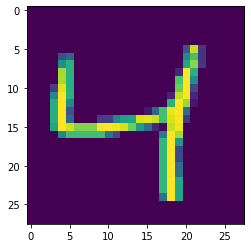

In [ ]:
def infer_data_labels(X_labels, cluster_labels):
  # empty array of len(X)
  predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

  for i, cluster in enumerate(X_labels):
      for key, value in cluster_labels.items():
          if cluster in value:
              predicted_labels[i] = key
            
  return predicted_labels

# test the infer_cluster_labels() and infer_data_labels() functions

cluster_labels = infer_cluster_labels(kmedoids, Y)
X_clusters = kmedoids.predict(X)
#X_clusters says that each ndarray belong to which cluster but the index is not as same as label of our mnist(digits)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print (predicted_labels[:10])
print (Y[:10])
plt.imshow(X[2].reshape(28,28))
plt.show()

As you can see 6 out of 10 of our predicts are labeled correctly.
so lets measure the accuracy of this method via purity function and rand index function.

In [ ]:
# purity measure function
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [ ]:
# rand index measurement function
from sklearn.metrics.cluster import adjusted_rand_score
def rand_index_score(y_true,y_pred):
  return adjusted_rand_score(y_true,y_pred)

In [ ]:
print(" rand index score of K median algorithm with K parameter of 10 is :" +str(rand_index_score(Y,predicted_labels)) )
print("purity  of K median algorithm with K parameter of 10 is :" +str(purity_score(Y,predicted_labels)) )

 rand index score of K median algorithm with K parameter of 10 is :0.16183265160699561
purity  of K median algorithm with K parameter of 10 is :0.33526666666666666


This low accuracy results is caused by clustering only half of dataset and if we use some learning methods to cluster with only a portion of dataset (only a small batch ) then each time we need to converge clusters as the result we get a better clustering .
